In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.patheffects as pe
import math
import hdbscan
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import scipy
import statsmodels.api as sm

In [2]:
basins = gpd.read_file('./census_geometry/WBD_HU2.shp')
basins = basins.to_crs(epsg=4326)
basins.head()

,objectid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc2,name,globalid,shape_Leng,shape_Area,geometry
0,1.0,{9F7DA17F-2AB2-4A27-B6AD-C3475BBA7C4A},{593C2F8D-2FB2-441A-8138-E5D5D99739B3},NaN,U.S. Geological Survey,NaN,2022/02/22 14:15:19.000,NaN,1.172620e+08,474542.91,"LA,NM,TX",12,Texas-Gulf Region,{35877C00-D26A-41C3-9F0D-206C9B5BE58E},43.122781,44.840044,"POLYGON ((-103.54138 34.68812, -103.54039 34.6..."
1,2.0,{7721F096-C381-4519-85C2-2FE21109F869},NaN,NaN,NaN,NaN,2019/12/05 11:32:03.000,NaN,3.846772e+06,15567.35,PR,21,Caribbean Region,{2112A6DE-FA49-4DC2-AB3C-9AEE503F07AF},10.105813,1.329539,"MULTIPOLYGON (((-67.09725 18.56686, -67.09633 ..."
2,3.0,{7271463E-B5E4-4017-8E10-24A186190541},{962ACAE6-5951-4092-A672-690F55332896},NaN,U.S. Geological Survey,NaN,2022/11/22 16:50:26.000,NaN,7.159207e+06,28972.31,HI,20,Hawaii Region,{2DD060A4-2AA4-4254-A72B-DFADC0203444},21.383554,2.520378,"MULTIPOLYGON (((-155.85308 20.31879, -155.8521..."
3,4.0,{4C2998C0-D39C-47B3-8848-549D9184B95B},NaN,NaN,NaN,NaN,2020/02/05 11:05:50.000,NaN,2.024969e+06,8194.77,"AS,GU",22,South Pacific Region,{5B166379-B4C7-4B81-A112-4BA6462EFC48},14.806282,0.688164,"MULTIPOLYGON (((144.94375 13.65124, 144.94392 ..."
4,5.0,{5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8},{77406B88-053A-4214-A171-C18FBEB10EFD},NaN,U.S. Geological Survey,NaN,2022/02/18 11:15:41.000,NaN,1.042701e+08,421966.31,"IL,IN,KY,MD,NC,NY,OH,PA,TN,VA,WV",05,Ohio Region,{1490E469-EB78-491F-A748-68AECEAB0F21},61.425278,43.813424,"POLYGON ((-79.03733 42.44862, -79.03682 42.448..."


In [11]:
basins_gsl = basins.loc[basins['name'] == 'Great Basin Region'].reset_index(drop=True)
basins_gsl

,objectid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc2,name,globalid,shape_Leng,shape_Area,geometry
0,12.0,{9567C98F-F09E-4C52-B2ED-C770AC69261B},NaN,NaN,NaN,NaN,2020/11/30 11:00:56.000,NaN,90699696.71,367048.97,"CA,ID,NV,OR,UT,WY",16,Great Basin Region,{64F307DD-6EAB-4D6F-8AB2-812723B9B30D},68.035805,38.576669,"POLYGON ((-111.64624 42.85187, -111.64585 42.8..."


In [5]:
dams.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Dam Name', 'Other Names', 'Former Names', 'NID ID',
       'Other Structure ID', 'Federal ID', 'Owner Names', 'Owner Types',
       'Primary Owner Type', 'State or Federal Agency ID',
       'Number of Associated Structures', 'Designer Names',
       'Non-Federal Dam on Federal Property', 'State Regulated Dam',
       'State Jurisdictional Dam', 'State Regulatory Agency',
       'State Permitting Authority', 'State Inspection Authority',
       'State Enforcement Authority', 'Source Agency', 'Latitude', 'Longitude',
       'County', 'State', 'City', 'Distance to Nearest City (Miles)',
       'River or Stream Name', 'USACE Division', 'USACE District',
       'Congressional District', 'Section, Township, or Range Location',
       'Federal Agency Owners', 'Federal Agency Involvement Funding',
       'Federal Agency Involvement Design',
       'Federal Agency Involvement Construction',
       'Federal Agency Involvement Regulatory',
       'Fe

In [21]:
dams = pd.read_csv('./data_plot/nation.csv', header=1)
dams = gpd.GeoDataFrame(dams, geometry=gpd.points_from_xy(dams.Longitude, dams.Latitude, crs="EPSG:4326"))
dams = dams.loc[dams['geometry'].is_valid].reset_index(drop=True)
dams.head()

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_69349/2823473339.py:1: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  dams = pd.read_csv('./data_plot/nation.csv', header=1)


,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Last EAP Exercise Date,Website URL,geometry
0,Aichi Forge Usa Dam,Aichi Forge Usa Lake,NaN,KY00728,NaN,KY00728,AICHI,Private,Private,KY00728,...,2013-04-30,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/kentucky,POINT (-84.55619 38.28828)
1,Oxy Usa Retention Pond,NaN,NaN,ND01160,NaN,ND01160,OXY USA Inc.,Private,Private,NaN,...,NaN,NaN,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/north-dakota,POINT (-102.77061 47.15639)
2,Dod Usa 2,NaN,Dod Usa,OK20994,NaN,OK20994,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/oklahoma,POINT (-95.13638 35.70341)
3,Dod Usa 4,NaN,Dod Usa,OK20998,NaN,OK20998,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/oklahoma,POINT (-95.18729 35.67191)
4,Exxonmobil Coal Usa/Mine 2/Recirculation Lake Dam,Make-Up Water Lake Dam,Monterey Coal Co/Mine 2/Recirculation Lake Dam,IL50526,NaN,IL50526,EXXONMOBIL ENVIRONMENTAL SERVICES COMPAN,Private,Private,NaN,...,2018-07-18,5.0,Low,Not Available,NaN,No,NaN,NaN,https://damsafety.org/illinois,POINT (-89.60861 38.53781)


In [15]:
basins_gsl.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
dams.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

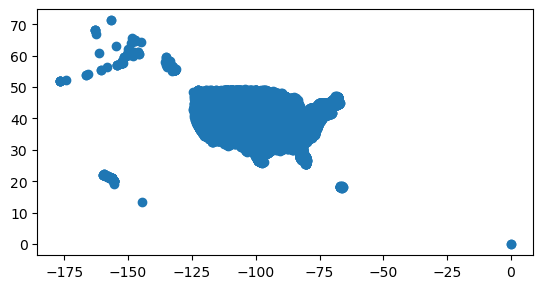

In [22]:
dams.plot()

In [24]:
dams_gsl = dams.loc[dams.apply(lambda x:x['geometry'].intersects(basins_gsl.geometry.values[0]), axis=1)].reset_index(drop=True)
dams_gsl

,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Last EAP Exercise Date,Website URL,geometry
0,Barrick Mercur Gold Mines 87r89,NaN,NaN,UT20816,NaN,UT20816,BARRICK RESOURCES (USA) INC.,Private,Private,UT20816,...,NaN,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/utah,POINT (-112.21199 40.32258)
1,Elko North Waste Water Ponds Dam,Treatment Plant Overflow Ponds,NaN,NV00206,NaN,NV00206,CITY OF ELKO,Local Government,Local Government,NaN,...,2017-11-16,5.0,Low,Fair,2017-11-16,Not Required,NaN,NaN,https://damsafety.org/nevada,POINT (-115.79068 40.81871)
2,Elko Percolation Pond 1b Dam,NaN,NaN,NV10707,NaN,NV10707,CITY OF ELKO,Local Government,Local Government,NaN,...,2017-08-08,5.0,Low,Not Rated,2017-08-08,Not Required,NaN,NaN,https://damsafety.org/nevada,POINT (-115.80704 40.78606)
3,Yearns,NaN,NaN,UT10103,NaN,UT10103,USDA FS,Federal,Federal,041001 0106,...,2019-08-07,10.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://www.fs.usda.gov/eng/dams/,POINT (-111.54376 39.25495)
4,Valmy Dam Evaporation Pond D,NaN,NaN,NV10761,NaN,NV10761,NV ENERGY - VALMY,Public Utility,Public Utility,NaN,...,2019-06-04,5.0,Low,Poor,2019-06-04,Not Required,NaN,NaN,https://damsafety.org/nevada,POINT (-117.16270 40.88728)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Barrick Goldstrike Tsf 3 Dam,NaN,NaN,NV10796,NaN,NV10796,NEVADA GOLD MINES LLC,Private,Private,J-662,...,2020-05-13,1.0,Significant,Not Rated,2020-05-13,Yes,2021-09-27,NaN,https://damsafety.org/nevada,POINT (-116.35914 40.99393)
956,Mill #4 Tailings #1 Dam,NaN,No 4 Mill Dam,NV10245,NaN,NV10245,NEVADA GOLD MINES LLC,Private,Private,J-309,...,2020-05-13,3.0,Significant,Not Rated,2020-05-13,Yes,2021-09-27,NaN,https://damsafety.org/nevada,POINT (-116.36110 40.98890)
957,Carlin Gold Tailings Dam,Newmont Mill #1 Tails Dam,Mill 1 Tailing Facility,NV00133,NaN,NV00133,NEVADA GOLD MINES LLC,Private,Private,J-354,...,2019-07-31,5.0,Low,Fair,2019-07-31,No,NaN,NaN,https://damsafety.org/nevada,POINT (-116.33060 40.91500)
958,Sawtooth Brine Pond #1,NaN,Magnum Ngls Pond 1,UT53584,NaN,UT53584,"SAWTOOTH CAVERNS, LLC",Private,Private,UT53584,...,2019-05-22,2.0,Significant,Satisfactory,2013-11-25,Yes,NaN,NaN,https://damsafety.org/utah,POINT (-112.56833 39.48600)


In [25]:
dams_gsl.to_file('./dams_gsl.json')

In [7]:
dams

,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Last EAP Exercise Date,Website URL,geometry
0,Aichi Forge Usa Dam,Aichi Forge Usa Lake,NaN,KY00728,NaN,KY00728,AICHI,Private,Private,KY00728,...,2013-04-30,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/kentucky,POINT (38.28828 -84.55619)
1,Oxy Usa Retention Pond,NaN,NaN,ND01160,NaN,ND01160,OXY USA Inc.,Private,Private,NaN,...,NaN,NaN,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/north-dakota,POINT (47.15639 -102.77061)
2,Dod Usa 2,NaN,Dod Usa,OK20994,NaN,OK20994,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/oklahoma,POINT (35.70341 -95.13638)
3,Dod Usa 4,NaN,Dod Usa,OK20998,NaN,OK20998,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,NaN,https://damsafety.org/oklahoma,POINT (35.67191 -95.18729)
4,Exxonmobil Coal Usa/Mine 2/Recirculation Lake Dam,Make-Up Water Lake Dam,Monterey Coal Co/Mine 2/Recirculation Lake Dam,IL50526,NaN,IL50526,EXXONMOBIL ENVIRONMENTAL SERVICES COMPAN,Private,Private,NaN,...,2018-07-18,5.0,Low,Not Available,NaN,No,NaN,NaN,https://damsafety.org/illinois,POINT (38.53781 -89.60861)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91752,Bluestone Dam,Bluestone Lake,NaN,WV08902,NaN,WV08902,USACE - Huntington District,Federal,Federal,NaN,...,2019-10-11,5.0,High,Not Available,NaN,Yes,2018-01-30,2022-02-15,https://www.lrh.usace.army.mil/Missions/Civil-...,POINT (37.64079 -80.88637)
91753,Foster Dam,Foster Lake,NaN,OR00012,NaN,OR00012,USACE - Portland District,Federal,Federal,NaN,...,2020-05-18,5.0,High,Not Available,NaN,Yes,2008-08-25,2022-10-07,https://www.nwp.usace.army.mil/Locations/Willa...,POINT (44.41561 -122.67016)
91754,Lockport Lock and Controlling Works,NaN,Lockport Lock and Dam,IL00007,NaN,IL00007,USACE - Chicago District,Federal,Federal,NaN,...,2020-03-01,1.0,High,Not Available,NaN,Yes,2009-03-01,2022-10-04,https://www.usace.army.mil/Missions/Civil-Work...,POINT (41.56893 -88.07805)
91755,Lewisville Dam,NaN,Garza Little Elm Dam,TX00008,NaN,TX00008,USACE - Fort Worth District,Federal,Federal,NaN,...,2019-03-08,5.0,High,Not Available,NaN,Yes,2021-09-24,2023-01-12,https://www.swf-wc.usace.army.mil/lewisville/,POINT (33.06932 -96.96454)
